# Custom Environments and Wrappers in Gymnasium

Before I can build and run a version of the Embodied Communication Game, I must learn how to build custom environments in Gymnasium. Here I'm going to run through a few tutorials on building custom `Envs` and modifying them with custom `wrappers`.

## Designing Custom Environments

In [1]:
# GYMNASIUM IMPORTS
from typing import Optional
import numpy as np
import gymnasium as gym
import os

# SB3 ALGORITHM IMPORTS
from stable_baselines3 import A2C, PPO, DQN, HerReplayBuffer
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

# CUSTOM PLOTTING FUNCTIONS
from functions import plot_results, plot_multi

In [2]:
class GridWorldEnv(gym.Env):

    # Initializes the environment with specific attributes including size, observation_space, action_space, and any other variables
    # defining the agent, environment, or reward structure.
    def __init__(self, size: int = 5):
        # The size of the square grid
        self._size = size

        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(4)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
        }

    # A common design pattern is to include a _get_obs method for translating state into an observation. However, this helper method
    # is not mandatory, and you might want to compute observations directly in env.reset and env.step, which may be preferable if
    # you want to compute them differently in each method call.
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    # A similar pattern, _get_info can be used to return auxiliary information. In this Env, we would like to calculate and return
    # Manhattan distance from the agent to the target square.
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

    # Reset is called to initiate a new episode for an environment and has two parameters, seed and options. Seed initializes the
    # random number generator to allow us to consistently generate the same environment when there are random variables involved.
    # Options is a dict containing any additional parameters we might want to specify during the reset.\

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self._size, size=2, dtype=int)
        # Sample random target locations until they do not coincide with the agent's starting location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self.agent_location):
            self._target_location = self.np_random.integers(
                0, self._size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to a direction on the map, using our helper dictionary
        direction = self._action_to_direction[action]
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self._size - 1
        )

        # We use `np.clip` to make sure we don't leave the grid bound
        terminated = np.array_equal(self._agent_location, self._target_location)
        truncated = False
        reward = 1 if terminated else 0
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info


# Now that we've defined the environment in it's own class, we can register it with gymnasium under a particular namespace
# which we can then call gym.make() on to instantiate this custom environment.
gym.register(id="GridWorld-v0", entry_point=GridWorldEnv)

In [3]:
# Instantiating the registered version of our custom environment using gym.make().
gym.make("GridWorld-v0")

<OrderEnforcing<PassiveEnvChecker<GridWorldEnv<GridWorld-v0>>>>

# Designing my own Custom Environment

### Simplified single-player color-matching game

Now I'll design my own custom environment in grid world. It will have elements of the ECG, but be designed to be solvable by a single player. In this environment, the agent will have to travel to a square whose color matches another given color. The squares will be inside of a 4x4 grid and the colors and starting position of the agent will be randomized.

In [2]:
class SimpleColorGame(gym.Env):
    # Initializes the Env, including observation space and action space. This one initializes the Observation space as a grid
    # of boxes with colors assigned to them, and the action space as the movement of the agent along the grid.
    def __init__(self, size=2, step_limit=200):
        # The size of one side of the square grid. It will be NxN squares in area, where N is self._size
        self._size = size
        self._num_colors = size**2

        # This is a time limit on the number of steps the agent is allowed to take in the game. This is necessary to
        # prevent the game from running forever if the agent's policy prevents it from moving or reaching the target.
        self._step_limit = step_limit
        # Integer to keep track of the number of steps taken in a particular iteration of the game
        self._step_count = 0

        # The agent location is stored inside of a local variable.
        self._agent_location = np.array([-1, -1], dtype=np.int32)

        # The colors of the boxes are also stored in a local variable. These colors are randomized on start-up. For this
        # version of the game, I will substitute integer values for colors.
        self._square_colors = np.arange(self._num_colors).reshape(size, size)

        # The target color will be a random number between 1 and 4. This number will be initialized during the reset() method.
        self._target_color = np.random.randint(0, self._num_colors)

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
                "agent location": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "square colors": gym.spaces.Box(
                    0, self._num_colors - 1, shape=(size, size), dtype=int
                ),
                "target color": gym.spaces.Discrete(self._num_colors),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = gym.spaces.Discrete(4)

        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
        }

    # Helper method used to get the observation from the state, useful in reset and step methods. This version returns
    # the properties of agent location, square colors, and the target color.
    def _get_obs(self):
        return {
            "agent location": self._agent_location,
            "square colors": self._square_colors,
            "target color": self._target_color,
        }

    # Helper method used to get auxiliary information from the state. Currently returns nothing.
    def _get_info(self):
        info = {"info": None}
        return info

    # Helper method for calculating the reward from the state. This will be useful as I can override it in child classes.
    def _get_reward(self):
        reward = (
            1
            if (self._square_colors[tuple(self._agent_location)] == self._target_color)
            else 0
        )
        return reward

    # Reset the environment to an initial configuration. The initial state may involve some randomness, so the seed argument
    # is used to guarantee an identical initial state whenever reset() is called with that seed. Options is a dict containing
    # any additional parameters we might want to specify during the reset.
    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):

        # Firstly, we will call this method to seed self.np_random with the seed argument if given.
        super().reset(seed=seed)

        # Reset the step count to 0 for the new iteration of the game
        self._step_count = 0

        # Now randomly generate a starting location for the agent using self.np_random. We generate an array of size two
        # representing the agent's starting coordinates.
        self._agent_location = self.np_random.integers(0, self._size, size=2)

        # Generate a random permutation of the square colors, and reshape them into a sizeXsize grid.
        self._square_colors = self.np_random.permutation(self._num_colors).reshape(
            self._size, self._size
        )

        # Now we generate the target color, which is a random integer from 0 to self._num_colors inclusive.
        self._target_color = self.np_random.integers(0, self._num_colors)

        # Now we can return the observation and auxiliary info
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    # Takes an action as input and updates the state of the Env according to that Action. Step then returns an observation
    # containing the new Env state, as well as some other additional variables and info.
    def step(self, action):
        # First, iterate the step count by one
        self._step_count += 1

        # Next, we convert our action to a direction.
        direction = self._action_to_direction[action]

        # Then we add the direction coordinates to the agend coordinates to get the new agent location. We must clip the
        # agent location at the Box boundary, so the agent's coordinates are within 0 and self._size-1.
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self._size - 1
        )

        # Now we terminate the game and give the agent a reward if the square it's standing on is the target color.
        terminated = (
            self._square_colors[tuple(self._agent_location)] == self._target_color
        )

        # We also truncate the game if self._step_count > self._step_limit.
        truncated = self._step_count > self._step_limit

        # Reward is 1 if we are on the target color square, otherwise 0
        reward = self._get_reward()

        # Finally, use the helper functions to generate Obs and Info.
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info


# Now let's register this environment with a namespace and try calling gym.make on it later
gym.register(id="SimpleColorGame-v0", entry_point=SimpleColorGame)

In [5]:
# Let's see if the registration worked! We ran into a few errors with incorrect method/variable names, but after fixing those it appears this
# game was able to load!
env = gym.make("SimpleColorGame-v0")

## Learning in the Custom Env with Stable-Baselines

Now that I have a custom environment defined, I can try unleashing the Stable-Baselines RL algorithms on it to see if I can train a model to succeed. Of course, I have no idea currently if the environment is working properly, so I'll have to find out through trial and error.

In [71]:
print(
    "Mean Reward of A2C Model, Simple Color Game, NxN Grid, 10000 training timesteps\n"
)
for i in range(2, 7):
    env = gym.make("SimpleColorGame-v0", size=i, step_limit=(i**3))
    model_A2C = A2C("MultiInputPolicy", env, verbose=0)

    mean_reward_pre, std_reward_pre = evaluate_policy(
        model_A2C, env, n_eval_episodes=100
    )  # Pre-training evaluation
    model_A2C.learn(total_timesteps=10000)  # training the model
    mean_reward, std_reward = evaluate_policy(
        model_A2C, env, n_eval_episodes=100
    )  # Post-training evaluation

    print(
        f"{i}x{i}: Pre-training  [{mean_reward_pre:.2f} +/- {std_reward_pre:.2f}], Post-training [{mean_reward:.2f} +/- {std_reward:.2f}]"
    )

Mean Reward of A2C Model, Simple Color Game, NxN Grid, 10000 training timesteps



C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


2x2: Pre-training  [0.18 +/- 0.38], Post-training [0.67 +/- 0.47]
3x3: Pre-training  [0.20 +/- 0.40], Post-training [0.17 +/- 0.38]
4x4: Pre-training  [0.15 +/- 0.36], Post-training [0.12 +/- 0.32]
5x5: Pre-training  [0.05 +/- 0.22], Post-training [0.07 +/- 0.26]
6x6: Pre-training  [0.03 +/- 0.17], Post-training [0.12 +/- 0.32]


## A2C learned the simple color game!

It took some finagling, but the A2C model now works with my custom color game! I had to make one major modification to the Env to allow the model to learn the game: I added a time-limit, *self._step_limit*, which sets **Truncated** variable to *True* to unceremoniously end the game if the agent takes more than *N* steps without reaching the target square. I had to do this because the untrained A2C algorithm was deciding to stubbornly stay in the corner and not move at all, causing the game to last forever.

However, it looks like the model may just be learning to wander around the environment as much as possible to stumble upon the square of the correct color. I want it to use the color grid and the target color to reach the target square as fast as possible.

### Time-Discounting The Reward

Adding a time discounter to the reward the agent recieves should incentivise the model to be as fast as possible in reaching the target square. The simple way to do this is to decrement the reward by 1 for every step taken.

In [3]:
# I'll make this class extend the SimpleColorGame class. We just want to modify the reward function to subtract 0.1 for each step taken.
class TimedColorGame(SimpleColorGame):
    # Override the _get_reward() method to subtract 1/self._step_limit from the normal reward. This creates an incentive to reach the target
    # square quickly.
    def _get_reward(self):
        reward = (
            (1.0 - self._step_count / self._step_limit)
            if (self._square_colors[tuple(self._agent_location)] == self._target_color)
            else 0
        )
        return reward


gym.register(id="TimedColorGame-v0", entry_point=TimedColorGame)

## Is the A2C algorithm finding the correct square efficiently?

It's hard to tell if the A2C algorithm is finding the optimal path to the square of the target color, or if it's just moving around the tiny 2x2 grid. Let's instantiate some larger versions of this game to see how quickly the model is approaching the target square.

In [66]:
# We'll run the A2C algorithm for 5 instances of the game, from a 2x2 to a 6x6. Performance before and after learning
# will be compared for each game size.
print(
    "Mean Rewards for Timed Color Game with NxN grid-size, using A2C, 10000 training timesteps"
)
for i in range(2, 7):
    # Instantiate the TimedColorGame with size=i and step_limit = i^3, so any improvement in the trained model over
    # an untrained model should be apparent. Previously even the trained models appeared to be running into the step
    # limit.
    env = gym.make("TimedColorGame-v0", size=i, step_limit=(i**3))
    model_A2C = A2C("MultiInputPolicy", env, verbose=0)

    mean_reward_pre, std_reward_pre = evaluate_policy(
        model_A2C, env, n_eval_episodes=100
    )  # Pre-training evaluation
    model_A2C.learn(total_timesteps=10000)  # training the model
    mean_reward, std_reward = evaluate_policy(
        model_A2C, env, n_eval_episodes=100
    )  # Post-training evaluation
    print(
        f"{i}x{i}: Pre-training  [{mean_reward_pre:.2f} +/- {std_reward_pre:.2f}], Post-training [{mean_reward:.2f} +/- {std_reward:.2f}]"
    )

Mean Rewards for Timed Color Game with NxN grid-size, using A2C, 10000 training timesteps
2x2: Pre-training  [-1.62 +/- 1.22], Post-training [0.37 +/- 0.27]
3x3: Pre-training  [-2.31 +/- 1.60], Post-training [-2.36 +/- 1.56]
4x4: Pre-training  [-3.47 +/- 1.61], Post-training [-3.37 +/- 1.72]
5x5: Pre-training  [-4.50 +/- 1.71], Post-training [-4.20 +/- 2.07]
6x6: Pre-training  [-5.61 +/- 1.66], Post-training [-5.82 +/- 1.19]


### After testing the model repeatedly, it appears that it is not finding the correct square efficiently.

The model only shows significant improvement in the 2x2 square, which I assume is because it's just rnadomly walking around the edge until it stumbles upon the square of the correct color. I'll have to try modifying the algorithm or the game to more efficiently find the right square.

### Let's try adjusting the model.

In [82]:
# I'm going to try out different models and training paradigms on a 3x3 grid to see which, if any, of them can show
# improvement on the simple color game. I'm now realizing that these models come with a pre-programmed discount
# factor, so adding a time penalty to the reward structure is unnecessary and may be counterproductive at worst.
env = gym.make("TimedColorGame-v0", size=5, step_limit=500)
mPPO = PPO("MultiInputPolicy", env, verbose=0)
mDQN = DQN("MultiInputPolicy", env, verbose=0)
mA2C = A2C("MultiInputPolicy", env, verbose=0)

for model in [mPPO, mDQN, mA2C]:
    print(type(model))
    mean_reward_pre, std_reward_pre = evaluate_policy(
        model, env, n_eval_episodes=1000
    )  # Pre-training evaluation
    model.learn(total_timesteps=20000)  # training the model
    mean_reward, std_reward = evaluate_policy(
        model, env, n_eval_episodes=1000
    )  # Post-training evaluation
    print(
        f"5x5: Pre-training  [{mean_reward_pre:.2f} +/- {std_reward_pre:.2f}], Post-training [{mean_reward:.2f} +/- {std_reward:.2f}]"
    )

<class 'stable_baselines3.ppo.ppo.PPO'>
5x5: Pre-training  [0.08 +/- 0.26], Post-training [0.09 +/- 0.28]
<class 'stable_baselines3.dqn.dqn.DQN'>
5x5: Pre-training  [0.09 +/- 0.28], Post-training [0.09 +/- 0.28]
<class 'stable_baselines3.a2c.a2c.A2C'>
5x5: Pre-training  [0.09 +/- 0.28], Post-training [0.10 +/- 0.30]


### How does model training time correlate to model performance?

I expect to see an improvement in the performance of the models in the Color game given more training time. However, I somewhat naively assumed that 10,000 training timesteps (the number of training timesteps given in the SB3 training examples) would be sufficient to learn the Color Game for small grid sizes. A human player, for instance, would very quickly be able to play the game optimally, moving to the square with the target color in an average of 2 moves in the 3x3 version of the color game. The models which I've tested so far have come nowhere close to that performance within a 3x3 grid.

Perhaps I was incorrect in my estimate of what would be an adequate training time, and orders of magnitude greater training time is required for the models to achieve a performance comparable to a human player.

In [14]:
env = gym.make("TimedColorGame-v0", size=3, step_limit=27)

model_A2C = A2C("MultiInputPolicy", env, verbose=0)

mean_reward, std_reward = evaluate_policy(model_A2C, env, n_eval_episodes=100)
print(f"0 Training Timeteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

model_A2C.learn(total_timesteps=10000)

mean_reward, std_reward = evaluate_policy(model_A2C, env, n_eval_episodes=100)
print(f"10,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

model_A2C.save("TCG0.s3.A2C.Te4")

model_A2C.learn(total_timesteps=90000)

mean_reward, std_reward = evaluate_policy(model_A2C, env, n_eval_episodes=100)
print(f"100,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

model_A2C.save("TCG0.s3.A2C.Te5")

model_A2C.learn(total_timesteps=900000)

mean_reward, std_reward = evaluate_policy(model_A2C, env, n_eval_episodes=100)
print(
    f"1,000,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}"
)

model_A2C.save("TCG.s3.A2C.Te6")

0 Training Timeteps mean reward: 0.22 +/- 0.40
10,000 Training Timesteps mean reward: 0.12 +/- 0.32
100,000 Training Timesteps mean reward: 0.34 +/- 0.44
1,000,000 Training Timesteps mean reward: 0.59 +/- 0.39


## Increasing the Training Time beyond 10,000 Timesteps Significantly Improved performance!

It appears that the training time was correlated with a linear increase in performance. In fact, the bot actually showed a decrease in performance after 10,000 training timesteps, and achieved a very respectable average of 0.59 points per episode after 1,000,000 training timesteps. It just goes to show that the models can have a decrease in performance after some training, and may take a very large number of training timesteps to achieve optimal performance (10,000 timesteps is orders of magnitude away from the requirement for even a simple game like this one). I'd also like to see how the PPO model performs on this env after various numbers of training timesteps. 

In [17]:
env = gym.make("TimedColorGame-v0", size=3, step_limit=27)

mPPO = PPO("MultiInputPolicy", env, verbose=0)

mean_reward, std_reward = evaluate_policy(mPPO, env, n_eval_episodes=100)
print(f"0 Training Timeteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mPPO.learn(total_timesteps=10000)

mean_reward, std_reward = evaluate_policy(mPPO, env, n_eval_episodes=100)
print(f"10,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mPPO.save("TCG0.s3.PPO.Te4")

mPPO.learn(total_timesteps=100000)

mean_reward, std_reward = evaluate_policy(mPPO, env, n_eval_episodes=100)
print(f"100,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mPPO.save("TCG0.s3.PPO.Te5")

mPPO.learn(total_timesteps=1000000)

mean_reward, std_reward = evaluate_policy(mPPO, env, n_eval_episodes=100)
print(
    f"1,000,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}"
)

mPPO.save("TCG0.s3.PPO.Te6")

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


0 Training Timeteps mean reward: 0.08 +/- 0.26
10,000 Training Timesteps mean reward: 0.17 +/- 0.36
100,000 Training Timesteps mean reward: 0.22 +/- 0.40
1,000,000 Training Timesteps mean reward: 0.67 +/- 0.37


### PPO was also successful!

And it looks like this instance of PPO actually required a longer training time to achieve a similar performance in the task, as its performance after 100,000 timesteps was worse than the A2C model but its performance after 1,000,000 timesteps was slightly better! It's really interesting to see that a training inflection point occurs sometime between the 100K and 1,000,000 training timesteps. I would not have thought that it would take so many iterations for these models to learn how to complete this rather simple game.

### Now let's try the DQN model for shits and giggles


In [18]:
env = gym.make("TimedColorGame-v0", size=3, step_limit=27)

mDQN = DQN("MultiInputPolicy", env, verbose=0)

mean_reward, std_reward = evaluate_policy(mDQN, env, n_eval_episodes=100)
print(f"0 Training Timeteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mDQN.learn(total_timesteps=10000)

mean_reward, std_reward = evaluate_policy(mDQN, env, n_eval_episodes=100)
print(f"10,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mDQN.save("TCG0.s3.DQN.Te4")

mDQN.learn(total_timesteps=100000)

mean_reward, std_reward = evaluate_policy(mDQN, env, n_eval_episodes=100)
print(f"100,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

mDQN.save("TCG0.s3.DQN.Te5")

mDQN.learn(total_timesteps=1000000)

mean_reward, std_reward = evaluate_policy(mDQN, env, n_eval_episodes=100)
print(
    f"1,000,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}"
)

mDQN.save("TCG0.s3.DQN.Te6")

0 Training Timeteps mean reward: 0.16 +/- 0.35
10,000 Training Timesteps mean reward: 0.21 +/- 0.39
100,000 Training Timesteps mean reward: 0.25 +/- 0.42
1,000,000 Training Timesteps mean reward: 0.19 +/- 0.38


### The DQN Model got worse!

Interestingly, the DQN model appears to have decreased in performance between 100,000 and 1,000,000 training timesteps. I'm not sure about this, but I believe that the nature of this problem makes Q-tables rather useless, since the location of the starting and target square is randomized for each trial. I suspect this is why the DQN model had such abysmal performance after 1,000,000 timesteps. This is odd, however, since even if the bot ignores the target square, simply walking through each square in succession should yield an average reward of ~0.66 or more. In fact, I'm guessing that that's what the PPO and A2C models learned to do.

### Vectorizing Custom Environments in SB3

In [47]:
# I want to make a vec_env using SB3's make_vec_env util. It takes an env name as the primary argument, similar to
# gym.make(), as well as n_envs (number of envs to vectorize into) and env_kwargs (a dict for by-keyword arguments
# you would otherwise pass into gym.make(). VecEnvs are essentially multiple Envs stacked on top of each other,
# allowing for more efficient training of some models. However, some models will train worse on VecEnvs.
vec_env = make_vec_env(
    "TimedColorGame-v0", n_envs=10, env_kwargs={"size": 2, "step_limit": 4}
)

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(


In [49]:
for i in range(10):
    mPPO = PPO("MultiInputPolicy", vec_env, verbose=0)
    mPPO.learn(total_timesteps=10000)

    mean_reward, std_reward = evaluate_policy(mPPO, vec_env, n_eval_episodes=100)
    print(
        f"10,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}"
    )
for i in range(10):
    mPPO.learn(total_timesteps=100000)

    mean_reward, std_reward = evaluate_policy(mPPO, vec_env, n_eval_episodes=100)
    print(
        f"100,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}"
    )

10,000 Training Timesteps mean reward: 0.55 +/- 0.24
10,000 Training Timesteps mean reward: 0.20 +/- 0.32
10,000 Training Timesteps mean reward: 0.32 +/- 0.35
10,000 Training Timesteps mean reward: 0.41 +/- 0.35
10,000 Training Timesteps mean reward: 0.48 +/- 0.32
10,000 Training Timesteps mean reward: 0.23 +/- 0.34
10,000 Training Timesteps mean reward: 0.38 +/- 0.36
10,000 Training Timesteps mean reward: 0.53 +/- 0.26
10,000 Training Timesteps mean reward: 0.33 +/- 0.35
10,000 Training Timesteps mean reward: 0.42 +/- 0.32
100,000 Training Timesteps mean reward: 0.68 +/- 0.11
100,000 Training Timesteps mean reward: 0.67 +/- 0.12
100,000 Training Timesteps mean reward: 0.69 +/- 0.11
100,000 Training Timesteps mean reward: 0.67 +/- 0.12
100,000 Training Timesteps mean reward: 0.67 +/- 0.12
100,000 Training Timesteps mean reward: 0.69 +/- 0.11
100,000 Training Timesteps mean reward: 0.67 +/- 0.12
100,000 Training Timesteps mean reward: 0.69 +/- 0.11
100,000 Training Timesteps mean reward

### That is an optimal performance by the PPO model.

Assuming perfect behaviour, the agent should take an average of 1.5 steps to reach the target in the 2x2 Color Game. This results in an optimal mean reward of 0.625, +/- 0.125. If the agent were just making loops around the grid, its mean number of steps would be 2.5, and its mean reward would be 0.375 +/- 0.125. This score indicates that the PPO model is immediately taking the shortest path to the square of the target color!!!

In [28]:
# I'm going to train the A2C model as well just to see if it too can achieve a near-optimal performance.
mA2C = A2C("MultiInputPolicy", vec_env, verbose=0)

mA2C.learn(total_timesteps=1000000)

mean_reward, std_reward = evaluate_policy(mA2C, vec_env, n_eval_episodes=100)
print(
    f"1,000,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}"
)

mA2C.save("TCG0-s2-sl4-v6_A2C-Te6")

1,000,000 Training Timesteps mean reward: 0.40 +/- 0.37


### This reflects subpar performance by A2C.

Let's run the PPO Model once more for a longer time control to see if we can confirm the results.

In [30]:
mean_reward, std_reward = evaluate_policy(mPPO, vec_env, n_eval_episodes=10000)
print(
    f"1,000,000 Training Timesteps mean reward: {mean_reward:.2f} +/- {std_reward:.2f}"
)

1,000,000 Training Timesteps mean reward: 0.69 +/- 0.11


These models are still performing poorly at larger sizes, and take a long time to train on the 2x2 grid.

## Hindsight Experience Replay to improve performance.

I'm going to try to improve the model performance/learning time using a method known as Hindsight Experience Replay (HER). HER attempts to help the model learn about the environment even when it doesn't reach the goal state, by iteratively treating other states it reached as if they were the goal state. Essentially, it teaches the model how to reach various states in the environment other than the goal state. The model can use this information to aid in its learning how to reach the goal state. It's kind of hard to explain in an intuitive way, but there's an excellent blog which got me to understand it in an intuitive way: https://towardsdatascience.com/reinforcement-learning-with-hindsight-experience-replay-1fee5704f2f8

HER is most useful for large state-goal spaces in which it's extremely improbable for an untrained model to ever reach the goal state and get rewarded, meaning it's essentially impossible for conventional reinforcement learning to take place. The larger grid sizes in the color game are approaching that concept. Additionally, if I implement a version of the game where the agent has to 'stop' on the target square, that version of the game will likely be sparse and contain few rewards.

### Modifying the Color Game to fulfill GoalEnv interface.

In order to implement HER, I will need to modify the Color Game to fulfill the GoalEnv interface. It must include 'achieved goal' and 'desired goal' as keywords in the 'obervation' dict, as well as a function 'compute_goal' to compute the reward gained by the model given the 'achieved goal' and 'desired goal'. To implement this, I'm going to make a modified version of the Simple Color Game.

# sigh...

Apparently, for some reason Gymnasium doesn't support nested observation spaces (Tuple/Dict inside a Tuple/Dict). I was thinking for a second that I'm screwed, but I might actually be able to save this by having the current "observation" key within self._get_obs() just contain the agent's current location. In fact, I could try doing away with it altogether, as the relevant information is still there under the 'achieved goal' and 'desired goal' keys. I'm banking on the fact that the actual 'observation' is whatever is returned by self._get_obs(), and not the little section labeled 'observation' within that Dict.

In [45]:
# This GoalEnv class will be essentially the same as the Simple Color Game, but will include the variables achieved_goal and desired_goal,
# and a function relating them to a reward.
class SimpleColorGameGoalEnv(SimpleColorGame):
    # Override self.observation_space to include achieved_goal and desired_goal.
    def __init__(self, size=2, step_limit=200):
        super().__init__(size=size, step_limit=step_limit)
        self.observation_space = gym.spaces.Dict(
            {
                "achieved_goal": gym.spaces.Box(
                    0, self._size - 1, shape=(2,), dtype=int
                ),
                "desired_goal": gym.spaces.Discrete(self._num_colors),
                "square_colors": gym.spaces.Box(
                    0, self._num_colors - 1, shape=(self._size, self._size), dtype=int
                ),
            }
        )

    # Override self._get_obs() to include achieved_goal and desired_goal. It's actually returning the same 3 things,
    # we've just renamed agent location to 'achieved_goal' and target color to 'desired_goal' to match the interface.
    def _get_obs(self):
        return {
            "achieved_goal": self._agent_location,
            "desired_goal": self._target_color,
            "square_colors": self._square_colors,
        }

    # self.compute_reward function taking the achieved_goal and desired_goal as arguments
    def compute_reward(self, achieved_goal, desired_goal, info):
        square_colors = self._square_colors
        target_color = desired_goal
        agent_location = achieved_goal
        print(
            "square colors",
            square_colors,
            "desired goal",
            target_color,
            "self._target_color",
            self._target_color,
            "achieved goal",
            agent_location,
            "self._agent_location",
            self._agent_location,
            sep="\n",
        )

        reward = 1 if (square_colors[tuple(agent_location)] == target_color) else 0
        return reward

    # self.ompute_terminated will compute if the game is ended using achieved_goal, desired_goal, and external state.
    def compute_terminated(self, achieved_goal, desired_goal, info):
        # Since esentially terminated == bool(Reward), we can just call compute_reward and convert to bool.
        terminated = bool(compute_reward(self, achieved_goal, desired_goal, info=None))
        return terminated

    # We must also include self.compute_truncated to fulfill the class, though that doesn't require achieved_goal/desired_goal.
    def compute_truncated(self, achieved_goal, desired_goal, info):
        return self.step_count > self.step_limit


# Because implementing this interface improves the functionality of the game without changing any existing functionality,
# I'm registering this env as SimpleColorGame-v1, and I'll be using it from now on.
gym.register("SimpleColorGame-v1", entry_point=SimpleColorGameGoalEnv)

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment SimpleColorGame-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


# Plotting Model Performance in the Simple Color Game

Here I'll train the **A2C**, **PPO**, and **DQN** models in a 10-env VecMonitor implementation of the *SCG*, to graph their respective training times and performance.

In [5]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log"
game = "SCG-v0"
mPPO_dir = f"{log_dir}/{game}/mPPO/"
mA2C_dir = f"{log_dir}/{game}/mA2C/"
mDQN_dir = f"{log_dir}/{game}/mDQN/"

os.makedirs(mPPO_dir, exist_ok=True)
os.makedirs(mA2C_dir, exist_ok=True)
os.makedirs(mDQN_dir, exist_ok=True)

In [6]:
# I'll train the models on the simplest version of the SCG, a 2x2, to improve the model training time.
PPO_env = VecMonitor(
    make_vec_env(
        "TimedColorGame-v0", n_envs=10, env_kwargs={"size": 2, "step_limit": 100}),
    mPPO_dir
    )
A2C_env = VecMonitor(
    make_vec_env(
        "TimedColorGame-v0", n_envs=10, env_kwargs={"size": 2, "step_limit": 100}),
    mA2C_dir
    )
DQN_env = VecMonitor(
    make_vec_env(
        "TimedColorGame-v0", n_envs=10, env_kwargs={"size": 2, "step_limit": 100}),
    mDQN_dir
    )

mPPO = PPO('MultiInputPolicy', PPO_env)
mA2C = A2C('MultiInputPolicy', A2C_env)
mDQN = DQN('MultiInputPolicy', DQN_env)

mPPO.learn(100000, callback = EvalCallback(PPO_env, best_model_save_path = mPPO_dir, eval_freq = 5000, verbose = 0), progress_bar = True)
mA2C.learn(100000, callback = EvalCallback(A2C_env, best_model_save_path = mA2C_dir, eval_freq = 5000, verbose = 0), progress_bar = True)
mDQN.learn(100000, callback = EvalCallback(DQN_env, best_model_save_path = mDQN_dir, eval_freq = 5000, verbose = 0), progress_bar = True)

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Output()

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: 
WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: 
WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Output()

Output()

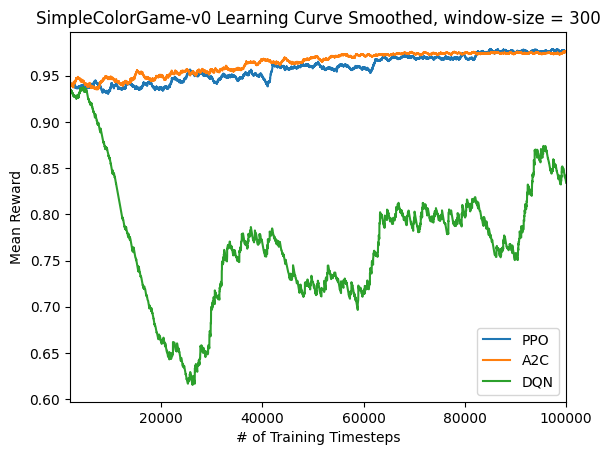

In [27]:
plot_multi([mPPO_dir, mA2C_dir, mDQN_dir],
           ["PPO","A2C","DQN"],
           x_range = [2000,100000],
           window = 300,
           title = "SimpleColorGame-v0 Learning Curve ")

### Plotting performance in a more complex version of the game

I will now plot model performance in the 3x3 TimedColorGame, which should give these models a tougher challenge.

In [30]:
log_dir = "C:/Users/Owner/Documents/GitHub/independent-study-F24-learning-RL-with-gymnasium/log"
game = "TCG-v0-s3"
mPPO_dir = f"{log_dir}/{game}/mPPO/"
mA2C_dir = f"{log_dir}/{game}/mA2C/"
mDQN_dir = f"{log_dir}/{game}/mDQN/"

os.makedirs(mPPO_dir, exist_ok=True)
os.makedirs(mA2C_dir, exist_ok=True)
os.makedirs(mDQN_dir, exist_ok=True)

PPO_env = VecMonitor(make_vec_env("TimedColorGame-v0", n_envs=10, env_kwargs={'size':3, 'step_limit':100}),mPPO_dir)
A2C_env = VecMonitor(make_vec_env("TimedColorGame-v0", n_envs=10, env_kwargs={'size':3, 'step_limit':100}),mA2C_dir)
DQN_env = VecMonitor(make_vec_env("TimedColorGame-v0", n_envs=10, env_kwargs={'size':3, 'step_limit':100}),mDQN_dir)

mPPO = PPO('MultiInputPolicy', PPO_env)
mA2C = A2C('MultiInputPolicy', A2C_env)
mDQN = DQN('MultiInputPolicy', DQN_env)

mPPO.learn(100000, callback = EvalCallback(PPO_env, best_model_save_path = mPPO_dir, eval_freq = 20000, verbose = 0), progress_bar = True)
mA2C.learn(100000, callback = EvalCallback(A2C_env, best_model_save_path = mA2C_dir, eval_freq = 20000, verbose = 0), progress_bar = True)
mDQN.learn(100000, callback = EvalCallback(DQN_env, best_model_save_path = mDQN_dir, eval_freq = 20000, verbose = 0), progress_bar = True)

Output()

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: 
WARN: The obs returned by the `step()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: 
WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")

C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\envs\registration.py:788: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: int64
  logger.warn(
C:\Users\Owner\anaconda3\envs\PythonRL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
 

Output()

Output()

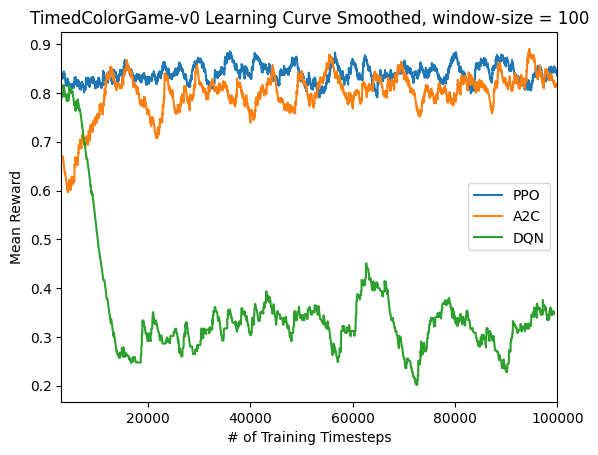

In [52]:
plot_multi(
    [mPPO_dir, mA2C_dir, mDQN_dir],
    ["PPO","A2C","DQN"],
    x_range = [3000,100000],
    gaussian = False,
    title = "TimedColorGame-v0 Learning Curve "
)